# Lab 2.2: Binary Classification Dataset Preparation

**Duration:** 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Load and preprocess real-world datasets for binary classification
- Handle missing values, outliers, and data quality issues
- Perform feature scaling and normalization
- Split datasets appropriately for training and testing
- Visualize and understand dataset characteristics
- Apply data preprocessing techniques essential for neural networks

## Prerequisites
- Python 3.8+
- NumPy, Pandas, Matplotlib, Seaborn
- Scikit-learn
- Jupyter Notebook/Lab

## Overview
Real-world data is rarely clean and ready for machine learning models. This lab focuses on the crucial data preparation steps that often determine the success or failure of your machine learning project. You'll work with multiple datasets and learn industry-standard preprocessing techniques.

## Step 1: Environment Setup and Imports

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib and seaborn
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Environment setup complete!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Environment setup complete!
NumPy version: 2.3.2
Pandas version: 2.3.2
Matplotlib version: 3.10.5
Seaborn version: 0.13.2


## Step 2: Load and Explore Real-World Dataset

We'll start with the famous Breast Cancer Wisconsin dataset - a real medical dataset used for binary classification.

In [3]:
# Load the breast cancer dataset
def load_breast_cancer_data():
    """
    Load and return the breast cancer dataset with proper formatting
    
    Returns:
    df -- pandas DataFrame with features and target
    X -- feature matrix
    y -- target vector
    feature_names -- names of features
    target_names -- names of target classes
    """
    # Load dataset
    data = load_breast_cancer()
    
    # Create DataFrame for easier manipulation
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target
    df['target_name'] = df['target'].map({0: 'malignant', 1: 'benign'})
    
    return df, data.data, data.target, data.feature_names, data.target_names

# Load the dataset
df, X_original, y_original, feature_names, target_names = load_breast_cancer_data()

print("Breast Cancer Wisconsin Dataset Loaded")
print("=" * 40)
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of samples: {len(df)}")
print(f"Target classes: {target_names}")
print(f"Class distribution:\n{df['target_name'].value_counts()}")

# Display first few rows
print("\nFirst 5 rows (selected columns):")
display_cols = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'target_name']
print(df[display_cols].head())

print("\n✓ Dataset loaded and initial exploration completed!")

Breast Cancer Wisconsin Dataset Loaded
Dataset shape: (569, 32)
Number of features: 30
Number of samples: 569
Target classes: ['malignant' 'benign']
Class distribution:
target_name
benign       357
malignant    212
Name: count, dtype: int64

First 5 rows (selected columns):
   mean radius  mean texture  mean perimeter  mean area target_name
0        17.99         10.38          122.80     1001.0   malignant
1        20.57         17.77          132.90     1326.0   malignant
2        19.69         21.25          130.00     1203.0   malignant
3        11.42         20.38           77.58      386.1   malignant
4        20.29         14.34          135.10     1297.0   malignant

✓ Dataset loaded and initial exploration completed!


## Step 3: Exploratory Data Analysis (EDA)

Before preprocessing, let's understand our data through visualization and statistical analysis.

In [4]:
# Basic statistical information
print("Dataset Statistical Summary")
print("=" * 30)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values: {missing_values.sum()} total")
if missing_values.sum() > 0:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("✓ No missing values found!")

# Data types
print(f"\nData types:")
print(df.dtypes.value_counts())

# Basic statistics for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numerical_features:
    numerical_features.remove('target')

print(f"\nNumerical features: {len(numerical_features)}")
print("Basic statistics (first 5 features):")
print(df[numerical_features[:5]].describe())

Dataset Statistical Summary
Shape: (569, 32)
Memory usage: 169.1 KB

Missing values: 0 total
✓ No missing values found!

Data types:
float64    30
int64       1
object      1
Name: count, dtype: int64

Numerical features: 30
Basic statistics (first 5 features):
       mean radius  mean texture  mean perimeter    mean area  mean smoothness
count   569.000000    569.000000      569.000000   569.000000       569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360
std       3.524049      4.301036       24.298981   351.914129         0.014064
min       6.981000      9.710000       43.790000   143.500000         0.052630
25%      11.700000     16.170000       75.170000   420.300000         0.086370
50%      13.370000     18.840000       86.240000   551.100000         0.095870
75%      15.780000     21.800000      104.100000   782.700000         0.105300
max      28.110000     39.280000      188.500000  2501.000000         0.163400


In [ ]:
# Visualize target class distribution
plt.figure(figsize=(15, 5))

# Class distribution
plt.subplot(1, 3, 1)
class_counts = df['target_name'].value_counts()
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')

# Class distribution bar plot
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='target_name')
plt.title('Class Counts')
plt.ylabel('Count')

# Target variable encoding
plt.subplot(1, 3, 3)
plt.bar(['Malignant (0)', 'Benign (1)'], [sum(y_original == 0), sum(y_original == 1)])
plt.title('Encoded Target Distribution')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Calculate class balance
class_balance = df['target'].value_counts(normalize=True)
print(f"Class balance:")
print(f"Benign (1): {class_balance[1]:.1%}")
print(f"Malignant (0): {class_balance[0]:.1%}")
print(f"Balance ratio: {class_balance[1]/class_balance[0]:.2f}:1")

print("\n✓ Target variable analysis completed!")

Feature Distributions by Class


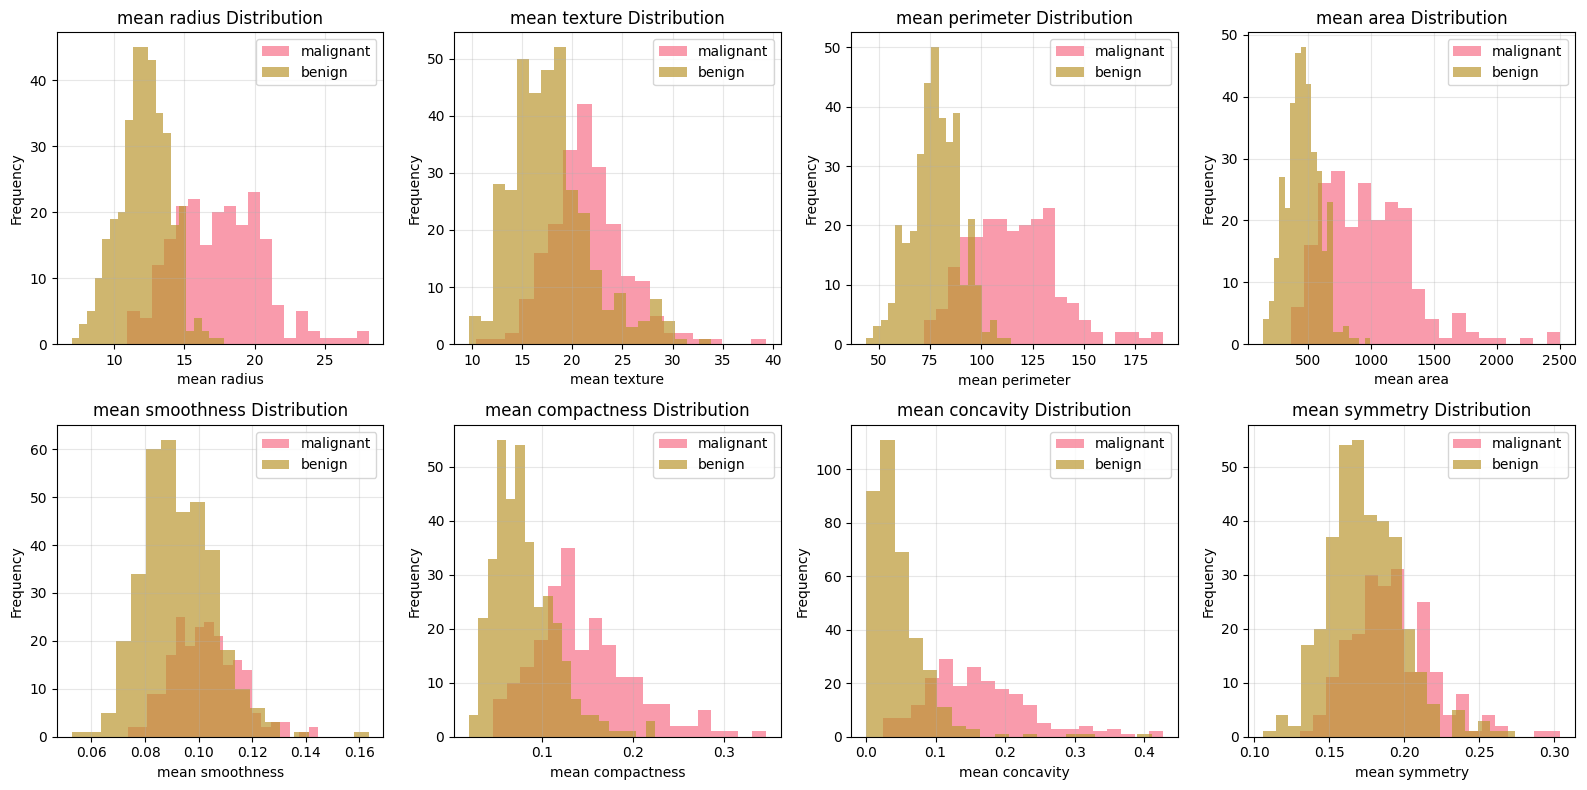

✓ Feature distribution analysis completed!


In [5]:
# Visualize feature distributions
def plot_feature_distributions(df, features, target_col='target_name', max_features=8):
    """
    Plot distribution of features by target class
    """
    features_to_plot = features[:max_features]  # Limit to first max_features
    n_features = len(features_to_plot)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    plt.figure(figsize=(16, 4 * n_rows))
    
    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Create separate histograms for each class
        for class_name in df[target_col].unique():
            data = df[df[target_col] == class_name][feature]
            plt.hist(data, alpha=0.7, label=class_name, bins=20)
        
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'{feature} Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot distributions for key features
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry']

print("Feature Distributions by Class")
plot_feature_distributions(df, key_features)

print("✓ Feature distribution analysis completed!")

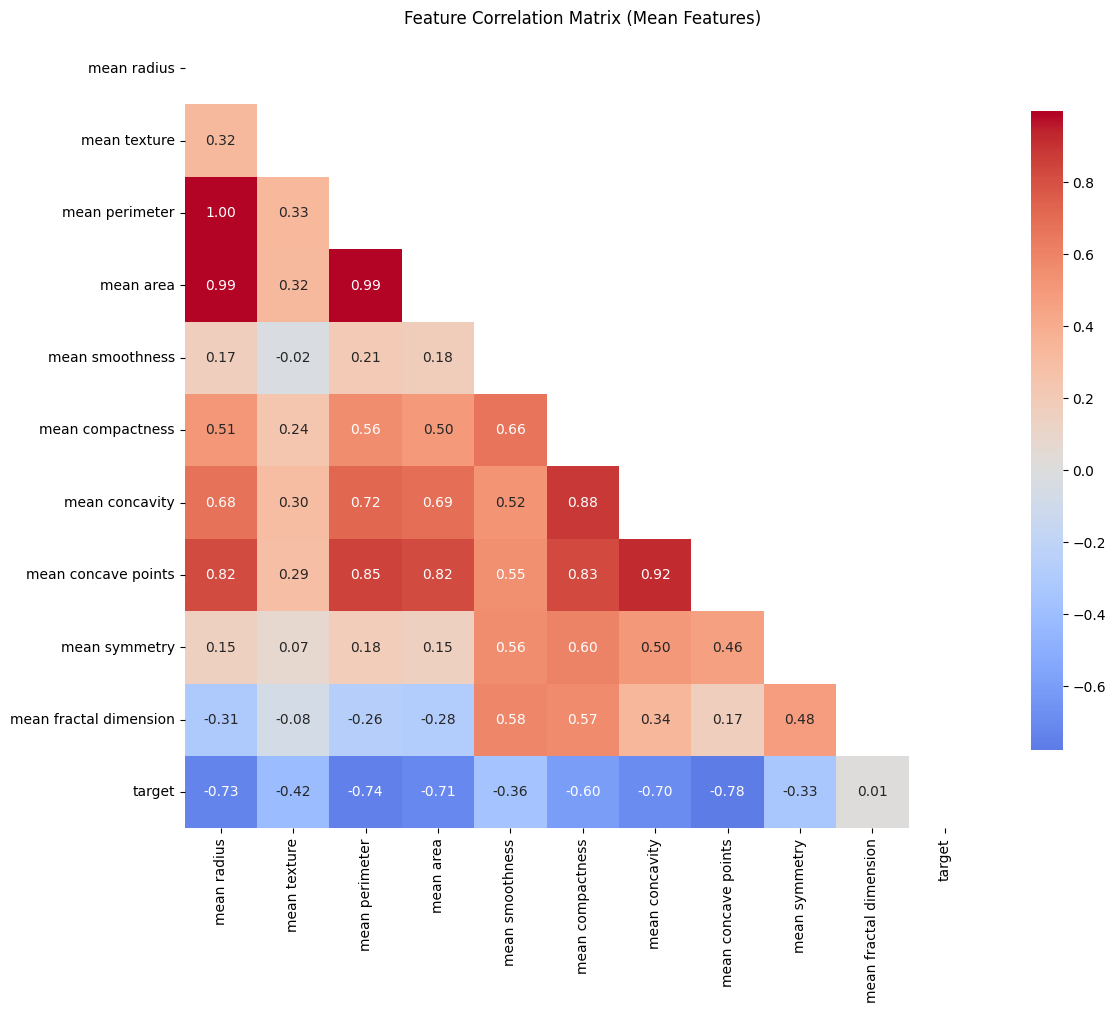


Highly correlated feature pairs (|r| > 0.8):
  mean radius <-> mean perimeter: 0.998
  mean radius <-> mean area: 0.987
  mean radius <-> mean concave points: 0.823
  mean perimeter <-> mean area: 0.987
  mean perimeter <-> mean concave points: 0.851
  mean area <-> mean concave points: 0.823
  mean compactness <-> mean concavity: 0.883
  mean compactness <-> mean concave points: 0.831
  mean concavity <-> mean concave points: 0.921

✓ Correlation analysis completed!


In [6]:
# Correlation analysis
# Select a subset of features for correlation analysis (too many features make the plot unreadable)
mean_features = [col for col in df.columns if 'mean' in col and col != 'target_name']
correlation_features = mean_features + ['target']

plt.figure(figsize=(12, 10))
correlation_matrix = df[correlation_features].corr()
mask = np.triu(correlation_matrix.corr())

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            mask=mask,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Matrix (Mean Features)')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.8:  # High correlation threshold
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))

print(f"\nHighly correlated feature pairs (|r| > 0.8):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

print("\n✓ Correlation analysis completed!")

## Step 4: Handle Data Quality Issues

Let's create a version of the dataset with some missing values and outliers to practice handling these common issues.

In [7]:
# Create a dataset with artificial missing values and outliers for practice
def introduce_data_issues(df, missing_rate=0.05, outlier_rate=0.02):
    """
    Introduce missing values and outliers to practice data cleaning
    
    Arguments:
    df -- original DataFrame
    missing_rate -- fraction of values to make missing
    outlier_rate -- fraction of values to make outliers
    
    Returns:
    df_with_issues -- DataFrame with data quality issues
    """
    df_issues = df.copy()
    
    # Select only numerical columns (exclude target and target_name)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['target', 'target_name']]
    
    # Introduce missing values
    n_missing = int(len(df_issues) * len(numerical_cols) * missing_rate)
    
    for _ in range(n_missing):
        row_idx = np.random.randint(0, len(df_issues))
        col_idx = np.random.choice(numerical_cols)
        df_issues.loc[row_idx, col_idx] = np.nan
    
    # Introduce outliers (extreme values)
    n_outliers = int(len(df_issues) * len(numerical_cols) * outlier_rate)
    
    for _ in range(n_outliers):
        row_idx = np.random.randint(0, len(df_issues))
        col_idx = np.random.choice(numerical_cols)
        
        # Make outlier by multiplying by large random factor
        current_val = df_issues.loc[row_idx, col_idx]
        if not pd.isna(current_val):
            outlier_factor = np.random.choice([0.01, 10.0])  # Very small or very large
            df_issues.loc[row_idx, col_idx] = current_val * outlier_factor
    
    return df_issues

# Create dataset with issues
df_with_issues = introduce_data_issues(df, missing_rate=0.03, outlier_rate=0.01)

print("Dataset with Artificial Data Quality Issues")
print("=" * 45)

# Check missing values
missing_counts = df_with_issues.isnull().sum()
missing_features = missing_counts[missing_counts > 0]

print(f"Features with missing values: {len(missing_features)}")
print(f"Total missing values: {missing_counts.sum()}")
print(f"Missing value rate: {missing_counts.sum() / (df_with_issues.shape[0] * df_with_issues.shape[1]):.1%}")

if len(missing_features) > 0:
    print("\nTop 5 features with missing values:")
    print(missing_features.head())

print("\n✓ Dataset with data quality issues created!")

Dataset with Artificial Data Quality Issues
Features with missing values: 30
Total missing values: 504
Missing value rate: 2.8%

Top 5 features with missing values:
mean radius        22
mean texture       18
mean perimeter     26
mean area          16
mean smoothness    25
dtype: int64

✓ Dataset with data quality issues created!


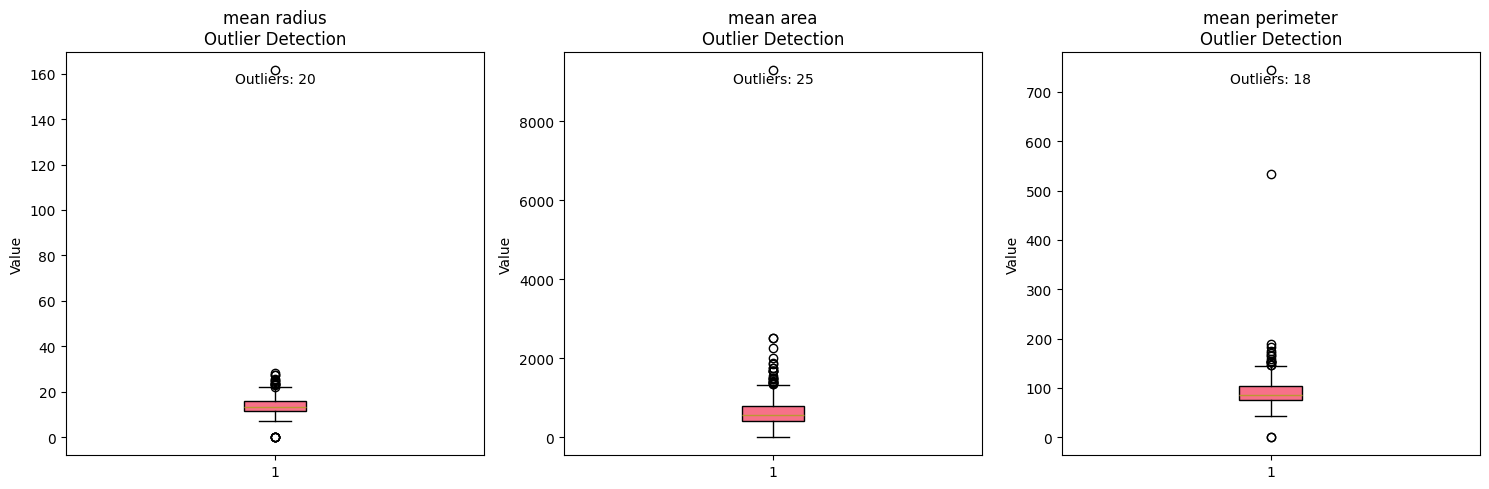

Outlier Analysis Summary
mean radius:
  Outliers: 20 (3.5%)
  Normal range: [5.40, 22.06]
mean area:
  Outliers: 25 (4.4%)
  Normal range: [-127.30, 1328.70]
mean perimeter:
  Outliers: 18 (3.2%)
  Normal range: [32.35, 146.59]

✓ Outlier detection completed!


In [8]:
# Detect and visualize outliers
def detect_outliers_iqr(df, feature):
    """
    Detect outliers using Interquartile Range (IQR) method
    
    Arguments:
    df -- DataFrame
    feature -- feature name to check for outliers
    
    Returns:
    outlier_indices -- indices of outlier rows
    lower_bound -- lower bound for normal values
    upper_bound -- upper bound for normal values
    """
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    
    return outlier_indices, lower_bound, upper_bound

# Analyze outliers in a few key features
outlier_analysis_features = ['mean radius', 'mean area', 'mean perimeter']

plt.figure(figsize=(15, 5))

outlier_summary = {}

for i, feature in enumerate(outlier_analysis_features):
    plt.subplot(1, 3, i + 1)
    
    # Create box plot
    plt.boxplot(df_with_issues[feature].dropna(), patch_artist=True)
    plt.title(f'{feature}\nOutlier Detection')
    plt.ylabel('Value')
    
    # Detect outliers
    outlier_indices, lower, upper = detect_outliers_iqr(df_with_issues, feature)
    outlier_summary[feature] = {
        'count': len(outlier_indices),
        'percentage': len(outlier_indices) / len(df_with_issues) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    
    # Add statistics text
    plt.text(0.5, 0.95, f'Outliers: {len(outlier_indices)}', 
             transform=plt.gca().transAxes, ha='center', va='top')

plt.tight_layout()
plt.show()

print("Outlier Analysis Summary")
print("=" * 25)
for feature, stats in outlier_summary.items():
    print(f"{feature}:")
    print(f"  Outliers: {stats['count']} ({stats['percentage']:.1f}%)")
    print(f"  Normal range: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")

print("\n✓ Outlier detection completed!")

## Step 5: Data Preprocessing Pipeline

Now let's create a comprehensive preprocessing pipeline to handle missing values, outliers, and scaling.

In [9]:
class DataPreprocessor:
    """
    Complete data preprocessing pipeline for binary classification
    """
    
    def __init__(self, missing_strategy='mean', outlier_method='iqr', 
                 scaling_method='standard', outlier_factor=1.5):
        """
        Initialize the preprocessor
        
        Arguments:
        missing_strategy -- strategy for handling missing values ('mean', 'median', 'mode')
        outlier_method -- method for outlier detection ('iqr', 'zscore')
        scaling_method -- scaling method ('standard', 'minmax', 'none')
        outlier_factor -- factor for outlier detection sensitivity
        """
        self.missing_strategy = missing_strategy
        self.outlier_method = outlier_method
        self.scaling_method = scaling_method
        self.outlier_factor = outlier_factor
        
        self.imputer = None
        self.scaler = None
        self.feature_names = None
        self.outlier_bounds = {}
        self.preprocessing_stats = {}
    
    def _handle_missing_values(self, X_train, X_test=None):
        """
        Handle missing values using imputation
        """
        if self.missing_strategy == 'mean':
            self.imputer = SimpleImputer(strategy='mean')
        elif self.missing_strategy == 'median':
            self.imputer = SimpleImputer(strategy='median')
        elif self.missing_strategy == 'mode':
            self.imputer = SimpleImputer(strategy='most_frequent')
        
        X_train_imputed = self.imputer.fit_transform(X_train)
        X_test_imputed = self.imputer.transform(X_test) if X_test is not None else None
        
        return X_train_imputed, X_test_imputed
    
    def _detect_and_handle_outliers(self, X, method='iqr'):
        """
        Detect and handle outliers
        """
        X_cleaned = X.copy()
        outlier_indices = set()
        
        for col_idx in range(X.shape[1]):
            column_data = X[:, col_idx]
            
            if method == 'iqr':
                Q1 = np.percentile(column_data, 25)
                Q3 = np.percentile(column_data, 75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.outlier_factor * IQR
                upper_bound = Q3 + self.outlier_factor * IQR
                
                outliers = np.where((column_data < lower_bound) | (column_data > upper_bound))[0]
                outlier_indices.update(outliers)
                
                # Store bounds for this feature
                self.outlier_bounds[col_idx] = (lower_bound, upper_bound)
                
                # Cap outliers to bounds
                X_cleaned[:, col_idx] = np.clip(column_data, lower_bound, upper_bound)
            
            elif method == 'zscore':
                z_scores = np.abs((column_data - np.mean(column_data)) / np.std(column_data))
                outliers = np.where(z_scores > 3)[0]
                outlier_indices.update(outliers)
                
                # Replace outliers with median
                median_val = np.median(column_data)
                X_cleaned[outliers, col_idx] = median_val
        
        return X_cleaned, list(outlier_indices)
    
    def _scale_features(self, X_train, X_test=None):
        """
        Scale features using specified method
        """
        if self.scaling_method == 'standard':
            self.scaler = StandardScaler()
        elif self.scaling_method == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.scaling_method == 'none':
            return X_train, X_test
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test) if X_test is not None else None
        
        return X_train_scaled, X_test_scaled
    
    def fit_transform(self, X_train, X_test=None, feature_names=None):
        """
        Fit the preprocessor and transform the data
        
        Arguments:
        X_train -- training features
        X_test -- test features (optional)
        feature_names -- names of features (optional)
        
        Returns:
        X_train_processed -- processed training features
        X_test_processed -- processed test features (if provided)
        """
        self.feature_names = feature_names
        
        print("Starting data preprocessing pipeline...")
        print("=" * 40)
        
        # Step 1: Handle missing values
        print(f"Step 1: Handling missing values using {self.missing_strategy} strategy")
        X_train_step1, X_test_step1 = self._handle_missing_values(X_train, X_test)
        missing_before = np.isnan(X_train).sum()
        missing_after = np.isnan(X_train_step1).sum()
        print(f"  Missing values: {missing_before} → {missing_after}")
        
        # Step 2: Handle outliers
        print(f"Step 2: Handling outliers using {self.outlier_method} method")
        X_train_step2, train_outlier_indices = self._detect_and_handle_outliers(
            X_train_step1, self.outlier_method)
        if X_test_step1 is not None:
            X_test_step2, test_outlier_indices = self._detect_and_handle_outliers(
                X_test_step1, self.outlier_method)
        else:
            X_test_step2 = None
            test_outlier_indices = []
        
        print(f"  Train outliers detected and handled: {len(train_outlier_indices)}")
        if X_test is not None:
            print(f"  Test outliers detected and handled: {len(test_outlier_indices)}")
        
        # Step 3: Feature scaling
        print(f"Step 3: Scaling features using {self.scaling_method} method")
        X_train_final, X_test_final = self._scale_features(X_train_step2, X_test_step2)
        
        if self.scaling_method != 'none':
            print(f"  Features scaled successfully")
        else:
            print(f"  No scaling applied")
        
        # Store preprocessing statistics
        self.preprocessing_stats = {
            'missing_values_imputed': missing_before,
            'train_outliers_handled': len(train_outlier_indices),
            'test_outliers_handled': len(test_outlier_indices),
            'scaling_method': self.scaling_method,
            'final_train_shape': X_train_final.shape,
            'final_test_shape': X_test_final.shape if X_test_final is not None else None
        }
        
        print("=" * 40)
        print("✓ Preprocessing pipeline completed!")
        
        return X_train_final, X_test_final
    
    def get_preprocessing_summary(self):
        """
        Get summary of preprocessing steps applied
        """
        return self.preprocessing_stats

print("✓ DataPreprocessor class implemented successfully!")

✓ DataPreprocessor class implemented successfully!


## Step 6: Apply Preprocessing Pipeline

Let's apply our preprocessing pipeline to the dataset with data quality issues.

In [10]:
# Prepare data for preprocessing
# Separate features and target
feature_columns = [col for col in df_with_issues.columns 
                  if col not in ['target', 'target_name']]

X_with_issues = df_with_issues[feature_columns].values
y_with_issues = df_with_issues['target'].values

# Split into train and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_with_issues, y_with_issues, test_size=0.2, random_state=42, stratify=y_with_issues
)

print("Data prepared for preprocessing")
print("=" * 32)
print(f"Training set shape: {X_train_raw.shape}")
print(f"Test set shape: {X_test_raw.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"Missing values in train set: {np.isnan(X_train_raw).sum()}")
print(f"Missing values in test set: {np.isnan(X_test_raw).sum()}")

Data prepared for preprocessing
Training set shape: (455, 30)
Test set shape: (114, 30)
Number of features: 30
Missing values in train set: 415
Missing values in test set: 89


In [11]:
# Compare different preprocessing strategies
preprocessing_configs = [
    {'name': 'Basic', 'missing': 'mean', 'outlier': 'iqr', 'scaling': 'standard'},
    {'name': 'Robust', 'missing': 'median', 'outlier': 'iqr', 'scaling': 'standard'},
    {'name': 'MinMax', 'missing': 'mean', 'outlier': 'iqr', 'scaling': 'minmax'},
    {'name': 'Z-score Outliers', 'missing': 'mean', 'outlier': 'zscore', 'scaling': 'standard'}
]

preprocessing_results = {}

for config in preprocessing_configs:
    print(f"\nTesting {config['name']} preprocessing strategy:")
    print("-" * 50)
    
    # Create preprocessor
    preprocessor = DataPreprocessor(
        missing_strategy=config['missing'],
        outlier_method=config['outlier'],
        scaling_method=config['scaling']
    )
    
    # Apply preprocessing
    X_train_processed, X_test_processed = preprocessor.fit_transform(
        X_train_raw.copy(), X_test_raw.copy(), feature_columns
    )
    
    # Store results
    preprocessing_results[config['name']] = {
        'preprocessor': preprocessor,
        'X_train': X_train_processed,
        'X_test': X_test_processed,
        'stats': preprocessor.get_preprocessing_summary()
    }

print("\n✓ All preprocessing strategies tested!")


Testing Basic preprocessing strategy:
--------------------------------------------------
Starting data preprocessing pipeline...
Step 1: Handling missing values using mean strategy
  Missing values: 415 → 0
Step 2: Handling outliers using iqr method
  Train outliers detected and handled: 210
  Test outliers detected and handled: 54
Step 3: Scaling features using standard method
  Features scaled successfully
✓ Preprocessing pipeline completed!

Testing Robust preprocessing strategy:
--------------------------------------------------
Starting data preprocessing pipeline...
Step 1: Handling missing values using median strategy
  Missing values: 415 → 0
Step 2: Handling outliers using iqr method
  Train outliers detected and handled: 210
  Test outliers detected and handled: 54
Step 3: Scaling features using standard method
  Features scaled successfully
✓ Preprocessing pipeline completed!

Testing MinMax preprocessing strategy:
--------------------------------------------------
Starting

## Step 7: Compare Preprocessing Results

Let's visualize and compare the effects of different preprocessing strategies.

Preprocessing Strategies Comparison
Strategy        Missing  Outliers   Scaling   
---------------------------------------------
Basic           415      210        standard  
Robust          415      210        standard  
MinMax          415      210        minmax    
Z-score Outliers 415      86         standard  


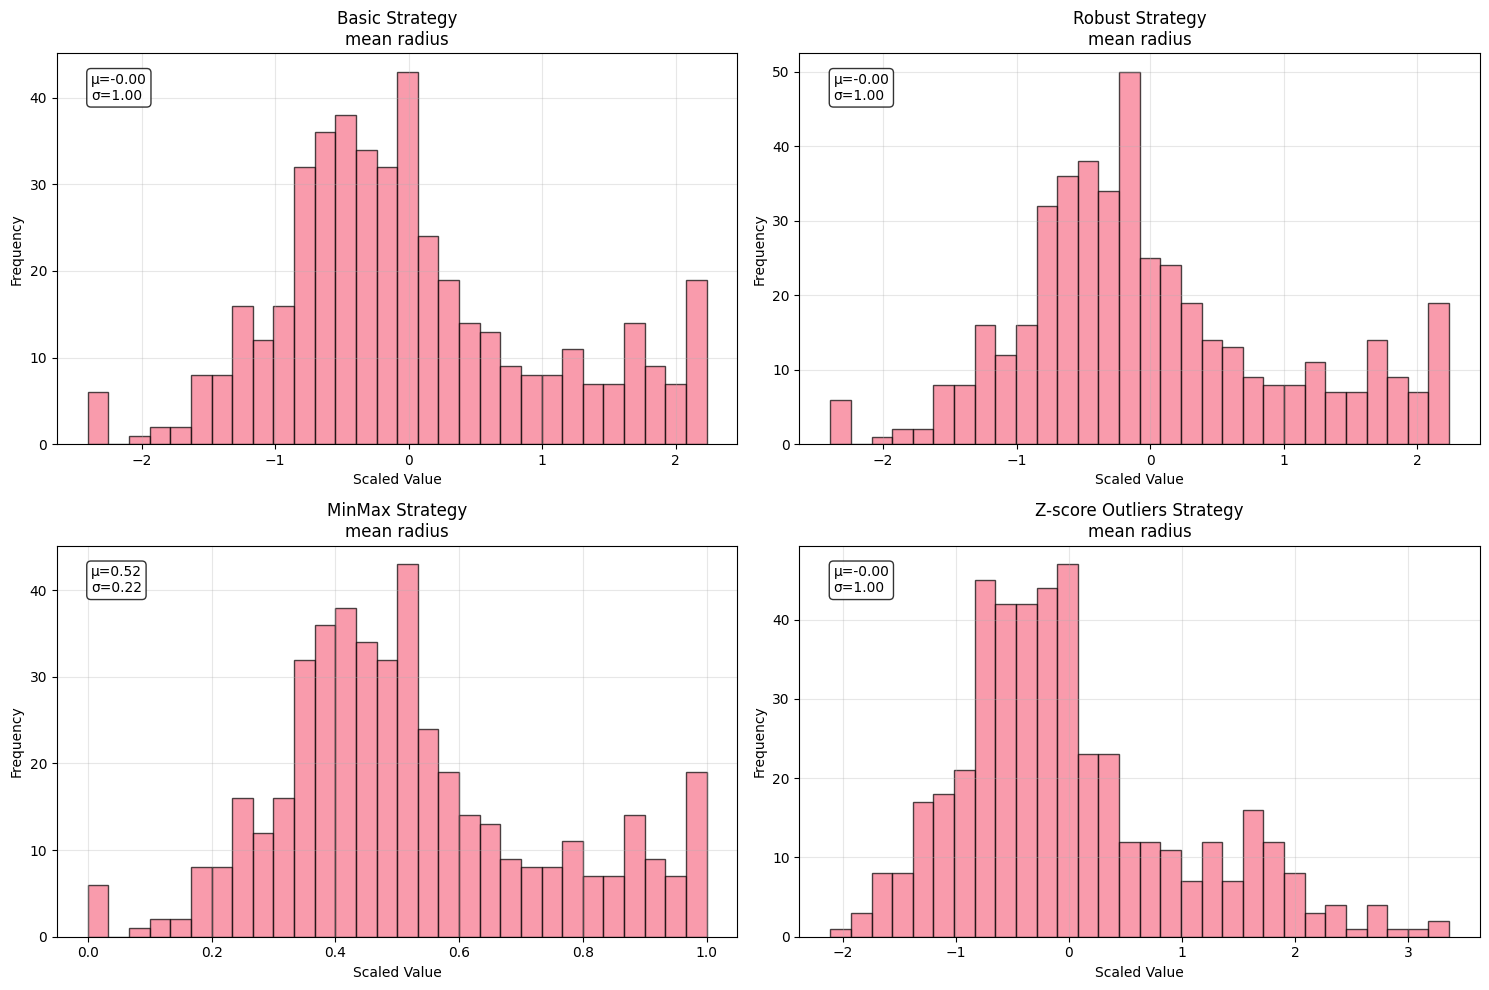


✓ Preprocessing comparison visualization completed!


In [12]:
# Compare preprocessing statistics
print("Preprocessing Strategies Comparison")
print("=" * 40)
print(f"{'Strategy':<15} {'Missing':<8} {'Outliers':<10} {'Scaling':<10}")
print("-" * 45)

for name, result in preprocessing_results.items():
    stats = result['stats']
    print(f"{name:<15} {stats['missing_values_imputed']:<8} "
          f"{stats['train_outliers_handled']:<10} {stats['scaling_method']:<10}")

# Visualize the effect of different scaling methods
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Select a feature for comparison
feature_idx = 0  # First feature
feature_name = feature_columns[feature_idx]

for i, (name, result) in enumerate(preprocessing_results.items()):
    if i >= 4:
        break
    
    ax = axes[i]
    
    # Plot distribution of the selected feature after preprocessing
    feature_data = result['X_train'][:, feature_idx]
    
    ax.hist(feature_data, bins=30, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name} Strategy\n{feature_name}')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(feature_data)
    std_val = np.std(feature_data)
    ax.text(0.05, 0.95, f'μ={mean_val:.2f}\nσ={std_val:.2f}', 
           transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✓ Preprocessing comparison visualization completed!")

In [ ]:
# Visualize before and after preprocessing for key features
def plot_before_after_preprocessing(X_before, X_after, feature_indices, feature_names, title):
    """
    Plot feature distributions before and after preprocessing
    """
    n_features = len(feature_indices)
    fig, axes = plt.subplots(n_features, 2, figsize=(12, 4 * n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for i, feat_idx in enumerate(feature_indices):
        # Before preprocessing
        axes[i][0].hist(X_before[:, feat_idx], bins=30, alpha=0.7, 
                       color='red', edgecolor='black')
        axes[i][0].set_title(f'Before: {feature_names[feat_idx]}')
        axes[i][0].set_ylabel('Frequency')
        axes[i][0].grid(True, alpha=0.3)
        
        # Add statistics for before
        before_data = X_before[:, feat_idx]
        before_data_clean = before_data[~np.isnan(before_data)]
        mean_before = np.mean(before_data_clean)
        std_before = np.std(before_data_clean)
        axes[i][0].text(0.05, 0.95, f'μ={mean_before:.2f}\nσ={std_before:.2f}', 
                       transform=axes[i][0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # After preprocessing
        axes[i][1].hist(X_after[:, feat_idx], bins=30, alpha=0.7, 
                       color='blue', edgecolor='black')
        axes[i][1].set_title(f'After: {feature_names[feat_idx]}')
        axes[i][1].set_ylabel('Frequency')
        axes[i][1].grid(True, alpha=0.3)
        
        # Add statistics for after
        mean_after = np.mean(X_after[:, feat_idx])
        std_after = np.std(X_after[:, feat_idx])
        axes[i][1].text(0.05, 0.95, f'μ={mean_after:.2f}\nσ={std_after:.2f}', 
                       transform=axes[i][1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Select the 'Basic' preprocessing strategy for detailed comparison
basic_result = preprocessing_results['Basic']
X_train_processed = basic_result['X_train']

# Show before/after for selected features
selected_feature_indices = [0, 3, 10]  # First few features
selected_feature_names = [feature_columns[i] for i in selected_feature_indices]

print("Before vs After Preprocessing (Basic Strategy)")
plot_before_after_preprocessing(
    X_train_raw, X_train_processed, 
    selected_feature_indices, feature_columns,
    "Feature Distributions: Before vs After Preprocessing"
)

print("\n✓ Before/after preprocessing visualization completed!")

## Step 8: Feature Analysis and Selection

Let's analyze the processed features and understand their importance for classification.

Feature Importance Analysis (Top 15)
Rank  Feature                   Correlation 
------------------------------------------
1     worst area                0.7894
2     worst concave points      0.7743
3     worst perimeter           0.7716
4     mean concave points       0.7648
5     mean area                 0.7493
6     worst radius              0.7466
7     mean perimeter            0.7186
8     mean radius               0.7177
9     mean concavity            0.7102
10    area error                0.7052
11    worst concavity           0.6706
12    perimeter error           0.6230
13    radius error              0.6181
14    worst compactness         0.5925
15    mean compactness          0.5690


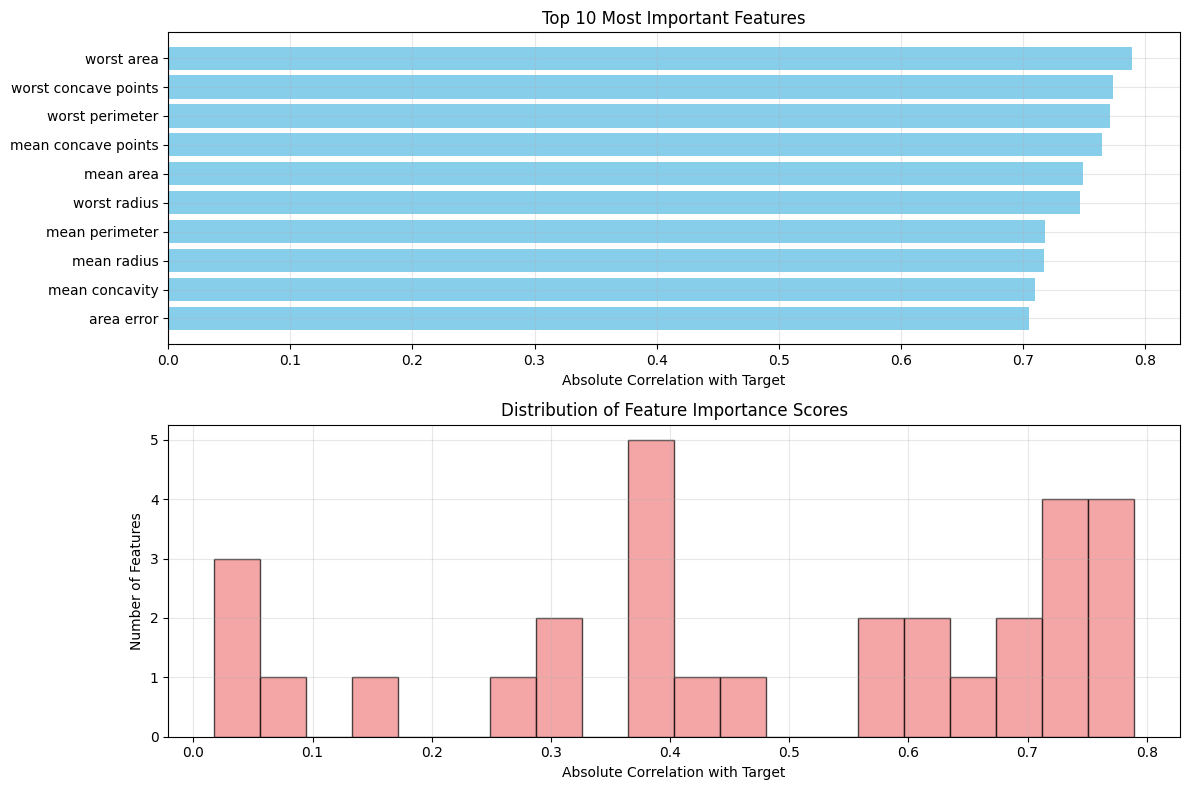


✓ Feature importance analysis completed!


In [13]:
# Analyze feature importance using correlation with target
def analyze_feature_importance(X, y, feature_names, top_k=10):
    """
    Analyze feature importance based on correlation with target
    
    Arguments:
    X -- feature matrix
    y -- target vector
    feature_names -- list of feature names
    top_k -- number of top features to display
    
    Returns:
    feature_importance -- DataFrame with feature importance scores
    """
    correlations = []
    
    for i in range(X.shape[1]):
        # Calculate correlation between feature and target
        corr = np.corrcoef(X[:, i], y)[0, 1]
        correlations.append(abs(corr))  # Use absolute correlation
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'correlation': correlations
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('correlation', ascending=False)
    
    return importance_df

# Analyze feature importance for preprocessed data
X_train_processed = preprocessing_results['Basic']['X_train']
feature_importance = analyze_feature_importance(X_train_processed, y_train, feature_columns, top_k=15)

print("Feature Importance Analysis (Top 15)")
print("=" * 40)
print(f"{'Rank':<5} {'Feature':<25} {'Correlation':<12}")
print("-" * 42)

for idx, (_, row) in enumerate(feature_importance.head(15).iterrows()):
    print(f"{idx+1:<5} {row['feature']:<25} {row['correlation']:.4f}")

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)

plt.subplot(2, 1, 1)
plt.barh(range(len(top_features)), top_features['correlation'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# Distribution of feature importance
plt.subplot(2, 1, 2)
plt.hist(feature_importance['correlation'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Absolute Correlation with Target')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Importance Scores')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis completed!")

## Step 9: Create Final Processed Dataset

Let's create the final processed dataset that's ready for machine learning models.

In [14]:
# Create the final processed dataset using the best preprocessing strategy
def create_final_dataset(preprocessing_results, strategy_name='Basic'):
    """
    Create final processed dataset ready for ML models
    
    Arguments:
    preprocessing_results -- dictionary of preprocessing results
    strategy_name -- name of the preprocessing strategy to use
    
    Returns:
    final_data -- dictionary containing processed data and metadata
    """
    result = preprocessing_results[strategy_name]
    
    final_data = {
        'X_train': result['X_train'],
        'X_test': result['X_test'],
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': feature_columns,
        'target_names': target_names,
        'preprocessing_stats': result['stats'],
        'preprocessor': result['preprocessor'],
        'strategy_used': strategy_name
    }
    
    return final_data

# Create final dataset
final_dataset = create_final_dataset(preprocessing_results, 'Basic')

print("Final Processed Dataset Summary")
print("=" * 35)
print(f"Training set shape: {final_dataset['X_train'].shape}")
print(f"Test set shape: {final_dataset['X_test'].shape}")
print(f"Number of features: {len(final_dataset['feature_names'])}")
print(f"Number of classes: {len(final_dataset['target_names'])}")
print(f"Preprocessing strategy: {final_dataset['strategy_used']}")

# Data quality verification
X_train_final = final_dataset['X_train']
X_test_final = final_dataset['X_test']

print("\nData Quality Verification:")
print("-" * 25)
print(f"Missing values in train: {np.isnan(X_train_final).sum()}")
print(f"Missing values in test: {np.isnan(X_test_final).sum()}")
print(f"Infinite values in train: {np.isinf(X_train_final).sum()}")
print(f"Infinite values in test: {np.isinf(X_test_final).sum()}")

# Feature statistics
print("\nFeature Statistics (after preprocessing):")
print("-" * 40)
print(f"Train set - Mean: {np.mean(X_train_final):.4f}, Std: {np.std(X_train_final):.4f}")
print(f"Train set - Min: {np.min(X_train_final):.4f}, Max: {np.max(X_train_final):.4f}")
print(f"Test set - Mean: {np.mean(X_test_final):.4f}, Std: {np.std(X_test_final):.4f}")
print(f"Test set - Min: {np.min(X_test_final):.4f}, Max: {np.max(X_test_final):.4f}")

print("\n✓ Final dataset created and verified!")

Final Processed Dataset Summary
Training set shape: (455, 30)
Test set shape: (114, 30)
Number of features: 30
Number of classes: 2
Preprocessing strategy: Basic

Data Quality Verification:
-------------------------
Missing values in train: 0
Missing values in test: 0
Infinite values in train: 0
Infinite values in test: 0

Feature Statistics (after preprocessing):
----------------------------------------
Train set - Mean: -0.0000, Std: 1.0000
Train set - Min: -2.7770, Max: 2.7653
Test set - Mean: 0.0533, Std: 0.9902
Test set - Min: -3.0323, Max: 3.5144

✓ Final dataset created and verified!


## Step 10: Save Processed Data for Future Use

Let's save our processed dataset so it can be easily loaded for the next labs.

In [15]:
# Function to save processed dataset
def save_processed_dataset(final_dataset, filename_prefix='processed_breast_cancer'):
    """
    Save processed dataset to numpy files
    
    Arguments:
    final_dataset -- dictionary containing processed data
    filename_prefix -- prefix for saved files
    """
    # Save arrays
    np.save(f'{filename_prefix}_X_train.npy', final_dataset['X_train'])
    np.save(f'{filename_prefix}_X_test.npy', final_dataset['X_test'])
    np.save(f'{filename_prefix}_y_train.npy', final_dataset['y_train'])
    np.save(f'{filename_prefix}_y_test.npy', final_dataset['y_test'])
    
    # Save metadata as text file
    with open(f'{filename_prefix}_metadata.txt', 'w') as f:
        f.write(f"Dataset: Breast Cancer Wisconsin (Processed)\n")
        f.write(f"Training samples: {final_dataset['X_train'].shape[0]}\n")
        f.write(f"Test samples: {final_dataset['X_test'].shape[0]}\n")
        f.write(f"Features: {final_dataset['X_train'].shape[1]}\n")
        f.write(f"Classes: {len(final_dataset['target_names'])}\n")
        f.write(f"Preprocessing strategy: {final_dataset['strategy_used']}\n")
        f.write(f"Target names: {', '.join(final_dataset['target_names'])}\n")
        f.write(f"\nFeature names:\n")
        for i, name in enumerate(final_dataset['feature_names']):
            f.write(f"{i:2d}: {name}\n")
    
    print(f"Dataset saved with prefix: {filename_prefix}")
    print(f"Files created:")
    print(f"  - {filename_prefix}_X_train.npy")
    print(f"  - {filename_prefix}_X_test.npy")
    print(f"  - {filename_prefix}_y_train.npy")
    print(f"  - {filename_prefix}_y_test.npy")
    print(f"  - {filename_prefix}_metadata.txt")

# Save the processed dataset
save_processed_dataset(final_dataset)

print("\n✓ Processed dataset saved successfully!")

Dataset saved with prefix: processed_breast_cancer
Files created:
  - processed_breast_cancer_X_train.npy
  - processed_breast_cancer_X_test.npy
  - processed_breast_cancer_y_train.npy
  - processed_breast_cancer_y_test.npy
  - processed_breast_cancer_metadata.txt

✓ Processed dataset saved successfully!


## Progress Tracking Checklist

Mark each completed section:

- [ ] ✅ **Environment Setup**: Imported libraries and configured environment
- [ ] ✅ **Dataset Loading**: Loaded real-world breast cancer dataset
- [ ] ✅ **Exploratory Data Analysis**: Analyzed distributions, correlations, and class balance
- [ ] ✅ **Data Quality Issues**: Introduced and detected missing values and outliers
- [ ] ✅ **Preprocessing Pipeline**: Implemented comprehensive DataPreprocessor class
- [ ] ✅ **Pipeline Application**: Applied different preprocessing strategies
- [ ] ✅ **Results Comparison**: Compared effects of different preprocessing approaches
- [ ] ✅ **Feature Importance**: Analyzed feature importance and correlations
- [ ] ✅ **Final Dataset**: Created clean, processed dataset ready for ML
- [ ] ✅ **Data Saving**: Saved processed data for future use

## Key Concepts Summary

**Data Preprocessing Fundamentals:**
1. **Missing Values**: Imputation strategies (mean, median, mode) preserve data integrity
2. **Outlier Detection**: IQR and Z-score methods identify anomalous values
3. **Feature Scaling**: StandardScaler (mean=0, std=1) and MinMaxScaler (range 0-1)
4. **Data Quality**: Verification ensures no missing/infinite values remain
5. **Feature Importance**: Correlation analysis identifies most predictive features

**Preprocessing Pipeline Benefits:**
- Consistent data transformation across train/test sets
- Reproducible preprocessing steps
- Proper handling of data leakage (fit on train, transform on test)
- Scalable to new data

**Best Practices Applied:**
- Always fit preprocessors on training data only
- Handle missing values before outlier detection
- Scale features after outlier handling
- Verify data quality after each step
- Document all preprocessing decisions

## Troubleshooting

**Common Issues and Solutions:**

1. **Memory Issues with Large Datasets**
   - *Problem*: Dataset too large to fit in memory
   - *Solution*: Process data in chunks or use data generators

2. **Scaling Issues**
   - *Problem*: Features have very different scales
   - *Solution*: Always apply feature scaling; try robust scaling for outliers

3. **Missing Value Patterns**
   - *Problem*: Missing values not random (MNAR)
   - *Solution*: Analyze missingness patterns; consider domain-specific imputation

4. **Outlier Sensitivity**
   - *Problem*: Too many/few outliers detected
   - *Solution*: Adjust outlier_factor parameter or try different methods

5. **Data Leakage**
   - *Problem*: Information from test set used in preprocessing
   - *Solution*: Always fit preprocessors on training data only

6. **Categorical Variables**
   - *Problem*: Non-numeric data types
   - *Solution*: Use LabelEncoder or OneHotEncoder before other preprocessing

## Validation Steps

**Verify Your Preprocessing:**
1. ✅ No missing values in final dataset
2. ✅ No infinite values in final dataset
3. ✅ Features are properly scaled (check mean/std for StandardScaler)
4. ✅ Train and test sets have consistent preprocessing
5. ✅ Feature importance analysis makes domain sense
6. ✅ Dataset saved successfully for future use

## Cleanup Instructions

**After Lab Completion:**
1. Save your notebook with all results
2. Keep processed data files for next labs
3. Clear large variables if memory is limited:
   ```python
   # Uncomment if needed
   # del df_with_issues, X_train_raw, X_test_raw
   # del preprocessing_results
   ```
4. Close plots: `plt.close('all')`

## Next Steps

Your processed dataset is now ready for machine learning! In the next lab, you'll:
- Load this processed data
- Implement gradient descent from scratch
- Train models on clean, scaled features
- Compare model performance with/without preprocessing

The preprocessing pipeline you built is reusable and can be applied to new datasets with similar characteristics.

**Congratulations! You've completed Lab 2.2 - Binary Classification Dataset Preparation!** 🎉